In [1]:
# Cell 1: Import libraries and setup
import pandas as pd
import numpy as np
import os
import sys
from random import randrange
import scipy
import gc
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import concurrent.futures
from functools import partial
import warnings
warnings.filterwarnings('ignore')

# GPU setup
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
Ravdess = "/content/drive/MyDrive/machine learning/input/Ravdess/audio_speech_actors_01-24"

# List directories in the RAVDESS dataset path
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    # List files for each actor in the directory
    actor = os.listdir(os.path.join(Ravdess, dir))
    for file in actor:
        part = file.split('.')[0].split('-')
        # Third part in each file represents the emotion associated to that file
        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(Ravdess, dir, file))

# Create a dataframe for emotions of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Create a dataframe for paths of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate the dataframes
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Replace integer labels with actual emotion names
Ravdess_df.Emotions.replace({
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}, inplace=True)

# Display the first few rows of the dataframe
Ravdess_df.head(20)

,Emotions,Path
0,surprise,/content/drive/MyDrive/machine learning/input/...
1,happy,/content/drive/MyDrive/machine learning/input/...
2,neutral,/content/drive/MyDrive/machine learning/input/...
3,angry,/content/drive/MyDrive/machine learning/input/...
4,happy,/content/drive/MyDrive/machine learning/input/...
5,surprise,/content/drive/MyDrive/machine learning/input/...
6,fear,/content/drive/MyDrive/machine learning/input/...
7,happy,/content/drive/MyDrive/machine learning/input/...
8,sad,/content/drive/MyDrive/machine learning/input/...
9,neutral,/content/drive/MyDrive/machine learning/input/...


In [4]:
Crema = "/content/drive/MyDrive/machine learning/input/Crema"

# List directories in the CREMA dataset path
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # Storing file paths
    file_path.append(os.path.join(Crema, file))
    # Storing file emotions
    part = file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# Dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate the dataframes
Crema_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
Crema_df.head(20)

,Emotions,Path
0,fear,/content/drive/MyDrive/machine learning/input/...
1,sad,/content/drive/MyDrive/machine learning/input/...
2,happy,/content/drive/MyDrive/machine learning/input/...
3,angry,/content/drive/MyDrive/machine learning/input/...
4,fear,/content/drive/MyDrive/machine learning/input/...
5,happy,/content/drive/MyDrive/machine learning/input/...
6,sad,/content/drive/MyDrive/machine learning/input/...
7,fear,/content/drive/MyDrive/machine learning/input/...
8,neutral,/content/drive/MyDrive/machine learning/input/...
9,happy,/content/drive/MyDrive/machine learning/input/...


In [5]:
Tess = "/content/drive/MyDrive/machine learning/input/Tess"

# List directories in the TESS dataset path
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(os.path.join(Tess, dir))
    for file in directories:
        part = file.split('.')[0].split('_')[2]
        # Handle the 'ps' for surprise, if it is there
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part.lower())  # Convert to lowercase for consistency
        file_path.append(os.path.join(Tess, dir, file))

# Dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate the dataframes
Tess_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
Tess_df.head(30)

,Emotions,Path
0,surprise,/content/drive/MyDrive/machine learning/input/...
1,surprise,/content/drive/MyDrive/machine learning/input/...
2,surprise,/content/drive/MyDrive/machine learning/input/...
3,surprise,/content/drive/MyDrive/machine learning/input/...
4,surprise,/content/drive/MyDrive/machine learning/input/...
5,surprise,/content/drive/MyDrive/machine learning/input/...
6,surprise,/content/drive/MyDrive/machine learning/input/...
7,surprise,/content/drive/MyDrive/machine learning/input/...
8,surprise,/content/drive/MyDrive/machine learning/input/...
9,surprise,/content/drive/MyDrive/machine learning/input/...


In [6]:
Savee = "/content/drive/MyDrive/machine learning/input/Savee"

# List directories in the SAVEE dataset path
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    # Storing file paths
    file_path.append(os.path.join(Savee, file))
    # Storing file emotions
    part = file.split('_')[1]
    ele = part[:2] if part.startswith('s') else part[0]
    if ele == 'a':
        file_emotion.append('angry')
    elif ele == 'd':
        file_emotion.append('disgust')
    elif ele == 'f':
        file_emotion.append('fear')
    elif ele == 'h':
        file_emotion.append('happy')
    elif ele == 'n':
        file_emotion.append('neutral')
    elif ele == 'sa':
        file_emotion.append('sad')
    elif ele == 'su':
        file_emotion.append('surprise')
    else:
        file_emotion.append('Unknown')

# Dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate the dataframes
Savee_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
Savee_df.head(20)

,Emotions,Path
0,disgust,/content/drive/MyDrive/machine learning/input/...
1,surprise,/content/drive/MyDrive/machine learning/input/...
2,neutral,/content/drive/MyDrive/machine learning/input/...
3,angry,/content/drive/MyDrive/machine learning/input/...
4,fear,/content/drive/MyDrive/machine learning/input/...
5,fear,/content/drive/MyDrive/machine learning/input/...
6,neutral,/content/drive/MyDrive/machine learning/input/...
7,angry,/content/drive/MyDrive/machine learning/input/...
8,neutral,/content/drive/MyDrive/machine learning/input/...
9,fear,/content/drive/MyDrive/machine learning/input/...


In [7]:
# Combining datasets into one dataframe
data_df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_df.head()

,Emotions,Path
0,surprise,/content/drive/MyDrive/machine learning/input/...
1,happy,/content/drive/MyDrive/machine learning/input/...
2,neutral,/content/drive/MyDrive/machine learning/input/...
3,angry,/content/drive/MyDrive/machine learning/input/...
4,happy,/content/drive/MyDrive/machine learning/input/...


In [8]:
# Checking label counts
data_df.Emotions.value_counts()

,count
Emotions,
happy,1794
angry,1794
fear,1794
sad,1793
disgust,1793
neutral,1638
surprise,522
calm,62


In [9]:
# Combining neutral and calm instances
data_df.loc[data_df['Emotions'] == 'neutral','Emotions'] = "calm"

In [10]:
# Checking label counts
data_df.Emotions.value_counts()

,count
Emotions,
happy,1794
fear,1794
angry,1794
sad,1793
disgust,1793
calm,1700
surprise,522


In [11]:
# Cell 2: Define constants and parameters
SAMPLE_RATE = 22050
DURATION = 3.0  # Fixed duration in seconds
N_SAMPLES = int(SAMPLE_RATE * DURATION)
N_MELS = 128
N_CHROMA = 12
HOP_LENGTH = 512
N_FFT = 2048

# Image dimensions for ResNet (minimum size)
IMG_HEIGHT = 224
IMG_WIDTH = 224

BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

print(f"Target samples per audio: {N_SAMPLES}")
print(f"Mel spectrogram shape: ({N_MELS}, {int(N_SAMPLES/HOP_LENGTH) + 1})")
print(f"Chroma shape: ({N_CHROMA}, {int(N_SAMPLES/HOP_LENGTH) + 1})")


Target samples per audio: 66150
Mel spectrogram shape: (128, 130)
Chroma shape: (12, 130)


In [12]:
# Cell 3: Feature extraction functions (optimized for memory)
def load_and_preprocess_audio(file_path, sr=SAMPLE_RATE, duration=DURATION):
    """Load and preprocess audio file"""
    try:
        # Load audio
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)

        # Pad or trim to fixed length
        if len(audio) < N_SAMPLES:
            # Pad with zeros
            audio = np.pad(audio, (0, N_SAMPLES - len(audio)), mode='constant')
        else:
            # Trim to fixed length
            audio = audio[:N_SAMPLES]

        return audio
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def extract_mel_spectrogram(audio, sr=SAMPLE_RATE):
    """Extract mel spectrogram"""
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH, n_fft=N_FFT
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Resize to target dimensions
    mel_spec_resized = tf.image.resize(
        mel_spec_db[..., np.newaxis],
        [IMG_HEIGHT, IMG_WIDTH]
    ).numpy().squeeze()

    # Normalize to 0-255 range
    mel_spec_norm = ((mel_spec_resized - mel_spec_resized.min()) /
                     (mel_spec_resized.max() - mel_spec_resized.min()) * 255).astype(np.uint8)

    return mel_spec_norm

def extract_chroma(audio, sr=SAMPLE_RATE):
    """Extract chroma features"""
    chroma = librosa.feature.chroma_stft(
        y=audio, sr=sr, hop_length=HOP_LENGTH, n_fft=N_FFT, n_chroma=N_CHROMA
    )

    # Resize to target dimensions
    chroma_resized = tf.image.resize(
        chroma[..., np.newaxis],
        [IMG_HEIGHT, IMG_WIDTH]
    ).numpy().squeeze()

    # Normalize to 0-255 range
    chroma_norm = ((chroma_resized - chroma_resized.min()) /
                   (chroma_resized.max() - chroma_resized.min()) * 255).astype(np.uint8)

    return chroma_norm

def process_single_file(file_info):
    """Process a single audio file"""
    file_path, emotion = file_info

    # Load audio
    audio = load_and_preprocess_audio(file_path)
    if audio is None:
        return None, None, None

    # Extract features
    mel_spec = extract_mel_spectrogram(audio)
    chroma = extract_chroma(audio)

    return mel_spec, chroma, emotion


In [13]:
# Cell 4: Batch processing with memory optimization
def process_audio_files_batch(file_paths, emotions, batch_size=100):
    """Process audio files in batches to manage memory"""

    mel_spectrograms = []
    chroma_features = []
    processed_emotions = []

    total_files = len(file_paths)

    for i in range(0, total_files, batch_size):
        batch_end = min(i + batch_size, total_files)
        batch_files = [(file_paths[j], emotions[j]) for j in range(i, batch_end)]

        print(f"Processing batch {i//batch_size + 1}/{(total_files-1)//batch_size + 1} "
              f"({i+1}-{batch_end}/{total_files})")

        # Process batch with multiprocessing
        with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
            results = list(executor.map(process_single_file, batch_files))

        # Collect results
        for mel, chroma, emotion in results:
            if mel is not None:
                mel_spectrograms.append(mel)
                chroma_features.append(chroma)
                processed_emotions.append(emotion)

        # Force garbage collection
        gc.collect()

    return np.array(mel_spectrograms), np.array(chroma_features), np.array(processed_emotions)


In [14]:
# Cell 5: Process the dataset
print("Starting feature extraction...")
print(f"Total files to process: {len(data_df)}")

# Extract file paths and emotions
file_paths = data_df['Path'].tolist()
emotions = data_df['Emotions'].tolist()

# Process all files
mel_spectrograms, chroma_features, processed_emotions = process_audio_files_batch(
    file_paths, emotions, batch_size=50
)

print(f"Processed {len(mel_spectrograms)} files successfully")
print(f"Mel spectrograms shape: {mel_spectrograms.shape}")
print(f"Chroma features shape: {chroma_features.shape}")


Starting feature extraction...
Total files to process: 11190
Processing batch 1/224 (1-50/11190)
Processing batch 2/224 (51-100/11190)
Processing batch 3/224 (101-150/11190)
Processing batch 4/224 (151-200/11190)
Processing batch 5/224 (201-250/11190)
Processing batch 6/224 (251-300/11190)
Processing batch 7/224 (301-350/11190)
Processing batch 8/224 (351-400/11190)
Processing batch 9/224 (401-450/11190)
Processing batch 10/224 (451-500/11190)
Processing batch 11/224 (501-550/11190)
Processing batch 12/224 (551-600/11190)
Processing batch 13/224 (601-650/11190)
Processing batch 14/224 (651-700/11190)
Processing batch 15/224 (701-750/11190)
Processing batch 16/224 (751-800/11190)
Processing batch 17/224 (801-850/11190)
Processing batch 18/224 (851-900/11190)
Processing batch 19/224 (901-950/11190)
Processing batch 20/224 (951-1000/11190)
Processing batch 21/224 (1001-1050/11190)
Processing batch 22/224 (1051-1100/11190)
Processing batch 23/224 (1101-1150/11190)
Processing batch 24/224 (

In [15]:
# Cell 6: Prepare data for training
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(processed_emotions)
y_categorical = to_categorical(y_encoded)

print(f"Classes: {label_encoder.classes_}")
print(f"Number of classes: {len(label_encoder.classes_)}")

# Expand dimensions for single channel grayscale
X_mel = np.expand_dims(mel_spectrograms, axis=-1)
X_chroma = np.expand_dims(chroma_features, axis=-1)

print(f"Final mel shape: {X_mel.shape}")
print(f"Final chroma shape: {X_chroma.shape}")
print(f"Labels shape: {y_categorical.shape}")

# Split the data
X_mel_train, X_mel_temp, X_chroma_train, X_chroma_temp, y_train, y_temp = train_test_split(
    X_mel, X_chroma, y_categorical, test_size=0.3, random_state=42, stratify=y_categorical
)

X_mel_val, X_mel_test, X_chroma_val, X_chroma_test, y_val, y_test = train_test_split(
    X_mel_temp, X_chroma_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_mel_train.shape[0]} samples")
print(f"Validation set: {X_mel_val.shape[0]} samples")
print(f"Test set: {X_mel_test.shape[0]} samples")

# Clear temporary variables
del mel_spectrograms, chroma_features, X_mel, X_chroma, X_mel_temp, X_chroma_temp, y_temp
gc.collect()


Classes: ['angry' 'calm' 'disgust' 'fear' 'happy' 'sad' 'surprise']
Number of classes: 7
Final mel shape: (11190, 224, 224, 1)
Final chroma shape: (11190, 224, 224, 1)
Labels shape: (11190, 7)
Training set: 7833 samples
Validation set: 1678 samples
Test set: 1679 samples


0

Displaying sample for emotion: happy


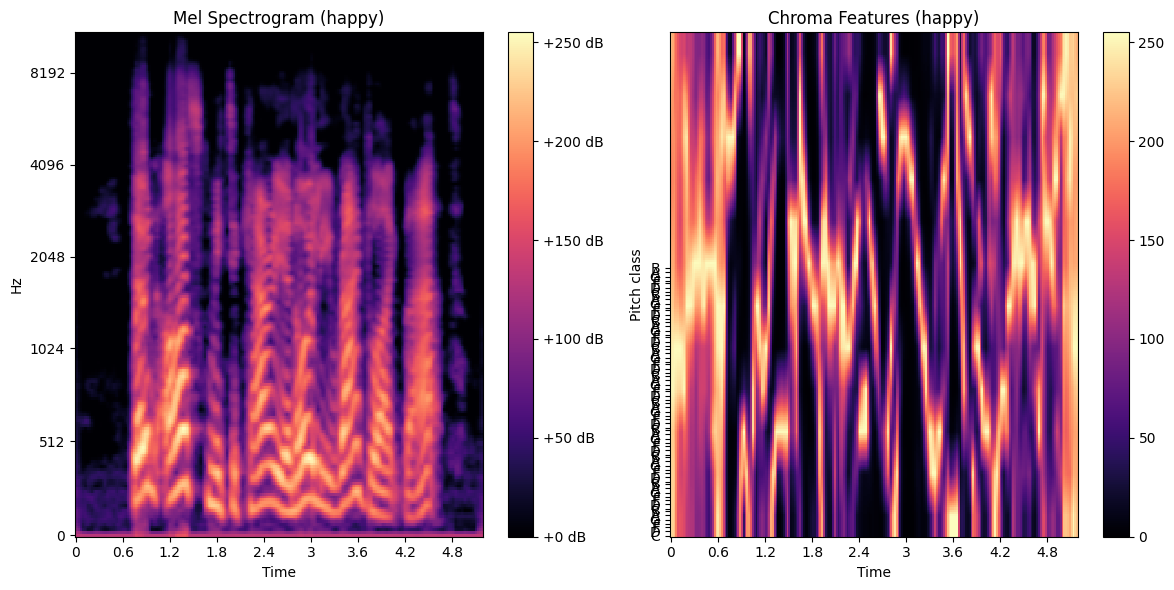

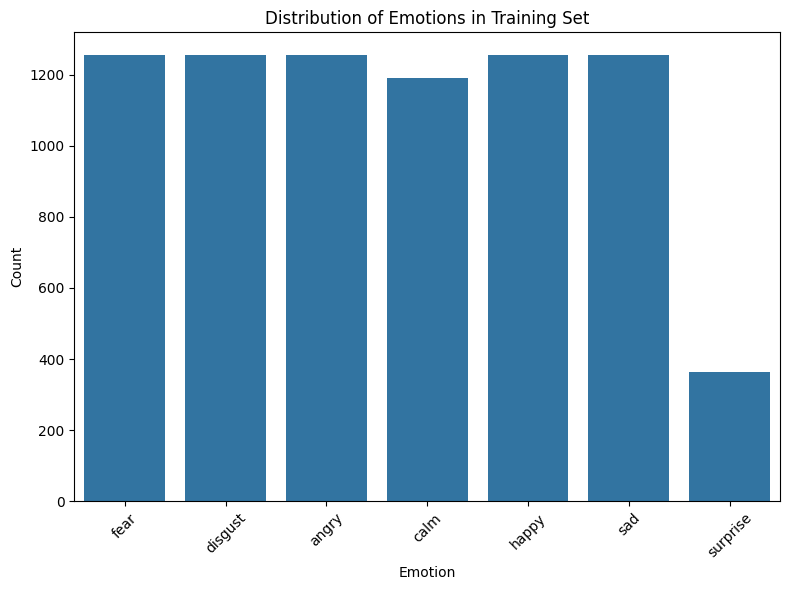

In [16]:

sample_index = randrange(X_mel_train.shape[0])
sample_mel = X_mel_train[sample_index].squeeze()
sample_chroma = X_chroma_train[sample_index].squeeze()
sample_label_encoded = np.argmax(y_train[sample_index])
sample_emotion = label_encoder.inverse_transform([sample_label_encoded])[0]

print(f"Displaying sample for emotion: {sample_emotion}")

# Plot Mel Spectrogram
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
librosa.display.specshow(sample_mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH,
                         x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spectrogram ({sample_emotion})')

# Plot Chroma Features
plt.subplot(1, 2, 2)
librosa.display.specshow(sample_chroma, sr=SAMPLE_RATE, hop_length=HOP_LENGTH,
                         x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title(f'Chroma Features ({sample_emotion})')

plt.tight_layout()
plt.show()

# Plot distribution of emotions in the training set
plt.figure(figsize=(8, 6))
sns.countplot(x=label_encoder.inverse_transform(np.argmax(y_train, axis=1)))
plt.title('Distribution of Emotions in Training Set')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Cell 7: Define multi-input ResNet model - FIXED
def create_multi_input_resnet(num_classes, input_shape=(224, 224, 1)):
    """Create a multi-input ResNet model for mel spectrogram and chroma features"""
    # Clear any existing models
    tf.keras.backend.clear_session()

    # Input layers
    mel_input = Input(shape=input_shape, name='mel_input')
    chroma_input = Input(shape=input_shape, name='chroma_input')

    # Convert single channel to 3 channels for ResNet
    mel_rgb = tf.keras.layers.Concatenate(axis=-1, name='mel_rgb_concat')([mel_input, mel_input, mel_input])
    chroma_rgb = tf.keras.layers.Concatenate(axis=-1, name='chroma_rgb_concat')([chroma_input, chroma_input, chroma_input])

    # Base ResNet50 models (without top layers) with unique names
    base_model_mel = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        name='resnet50_mel'
    )
    base_model_chroma = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        name='resnet50_chroma'
    )

    # FIXED: Set trainable property AFTER creation
    base_model_mel.trainable = True
    base_model_chroma.trainable = True

    # Extract features
    mel_features = base_model_mel(mel_rgb)
    chroma_features = base_model_chroma(chroma_rgb)

    # Global average pooling
    mel_pooled = GlobalAveragePooling2D(name='mel_gap')(mel_features)
    chroma_pooled = GlobalAveragePooling2D(name='chroma_gap')(chroma_features)

    # Combine features
    combined = Concatenate(name='feature_concat')([mel_pooled, chroma_pooled])

    # Classification head
    x = Dense(512, activation='relu', name='dense_512')(combined)
    x = BatchNormalization(name='bn_512')(x)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(256, activation='relu', name='dense_256')(x)
    x = BatchNormalization(name='bn_256')(x)
    x = Dropout(0.3, name='dropout_256')(x)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(inputs=[mel_input, chroma_input], outputs=outputs, name='multi_input_resnet')

    return model, base_model_mel, base_model_chroma

In [18]:
# Cell 8: Analyze ResNet architecture and define unfreezing strategies - MOSTLY OK
def analyze_resnet_blocks(model):
    """Analyze ResNet50 block structure"""
    blocks = []
    current_block = []

    for i, layer in enumerate(model.layers):
        layer_name = layer.name
        current_block.append((i, layer_name, layer.trainable_weights))

        # ResNet50 block boundaries
        if ('conv5_block3_out' in layer_name or
            'conv4_block6_out' in layer_name or
            'conv3_block4_out' in layer_name or
            'conv2_block3_out' in layer_name):
            blocks.append(current_block)
            current_block = []

    if current_block:
        blocks.append(current_block)

    return blocks

def count_trainable_parameters(model):
    """Count trainable parameters in the model"""
    return sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

def get_unfreezing_strategies(base_model_mel, base_model_chroma):
    """Define different unfreezing strategies"""
    strategies = {
        'last_10_layers': {
            'description': 'Last 10 layers unfrozen',
            'mel_trainable_layers': 10,
            'chroma_trainable_layers': 10
        },
        'frozen': {
            'description': 'All base model layers frozen',
            'mel_trainable_layers': 0,
            'chroma_trainable_layers': 0
        },
        'last_20_layers': {
            'description': 'Last 20 layers unfrozen',
            'mel_trainable_layers': 20,
            'chroma_trainable_layers': 20
        },
        'last_2_blocks': {
            'description': 'Last 2 ResNet blocks unfrozen (conv5_block and conv4_block)',
            'mel_layers_to_unfreeze': ['conv5_block', 'conv4_block'],
            'chroma_layers_to_unfreeze': ['conv5_block', 'conv4_block']
        },
        'last_3_blocks': {
            'description': 'Last 3 ResNet blocks unfrozen',
            'mel_layers_to_unfreeze': ['conv5_block', 'conv4_block', 'conv3_block'],
            'chroma_layers_to_unfreeze': ['conv5_block', 'conv4_block', 'conv3_block']
        }
    }
    return strategies

In [19]:
# Cell 9: Training utilities - MAJOR FIXES NEEDED
def apply_unfreezing_strategy(model, base_model_mel, base_model_chroma, strategy_name, strategy_config):
    """Apply unfreezing strategy to the model"""

    print(f"Applying unfreezing strategy: {strategy_name}")
    print(f"Base model mel layers: {len(base_model_mel.layers)}")
    print(f"Base model chroma layers: {len(base_model_chroma.layers)}")

    # First, freeze all layers in both base models
    for layer in base_model_mel.layers:
        layer.trainable = False
    for layer in base_model_chroma.layers:
        layer.trainable = False

    if strategy_name == 'frozen':
        print("Keeping all base model layers frozen")
        pass  # Keep all frozen

    elif 'mel_trainable_layers' in strategy_config:
        # Unfreeze last N layers
        n_layers_mel = strategy_config['mel_trainable_layers']
        n_layers_chroma = strategy_config['chroma_trainable_layers']

        print(f"Unfreezing last {n_layers_mel} layers in mel model")
        print(f"Unfreezing last {n_layers_chroma} layers in chroma model")

        # FIXED: Unfreeze last N layers for mel model
        if n_layers_mel > 0:
            # CRITICAL: Set base model trainable first
            base_model_mel.trainable = True
            for layer in base_model_mel.layers[-n_layers_mel:]:
                layer.trainable = True
                print(f"  Mel: Unfrozen layer {layer.name}")

        # FIXED: Unfreeze last N layers for chroma model
        if n_layers_chroma > 0:
            # CRITICAL: Set base model trainable first
            base_model_chroma.trainable = True
            for layer in base_model_chroma.layers[-n_layers_chroma:]:
                layer.trainable = True
                print(f"  Chroma: Unfrozen layer {layer.name}")

    elif 'mel_layers_to_unfreeze' in strategy_config:
        # Unfreeze specific blocks
        mel_blocks = strategy_config['mel_layers_to_unfreeze']
        chroma_blocks = strategy_config['chroma_layers_to_unfreeze']

        print(f"Unfreezing mel blocks: {mel_blocks}")
        print(f"Unfreezing chroma blocks: {chroma_blocks}")

        # Unfreeze mel blocks
        unfrozen_mel = 0
        for layer in base_model_mel.layers:
            if any(block in layer.name for block in mel_blocks):
                layer.trainable = True
                unfrozen_mel += 1
                print(f"  Mel: Unfrozen layer {layer.name}")

        if unfrozen_mel > 0:
            base_model_mel.trainable = True

        # Unfreeze chroma blocks
        unfrozen_chroma = 0
        for layer in base_model_chroma.layers:
            if any(block in layer.name for block in chroma_blocks):
                layer.trainable = True
                unfrozen_chroma += 1
                print(f"  Chroma: Unfrozen layer {layer.name}")

        if unfrozen_chroma > 0:
            base_model_chroma.trainable = True

        print(f"Total unfrozen layers: Mel={unfrozen_mel}, Chroma={unfrozen_chroma}")

    # CRITICAL FIX: Recompile model AFTER setting trainable status
    # Use a lower learning rate for fine-tuning
    learning_rate = 1e-5 if strategy_name != 'frozen' else LEARNING_RATE

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # ADDED: Verify the changes took effect
    print("\nVerification after unfreezing:")
    trainable_mel = sum(1 for layer in base_model_mel.layers if layer.trainable)
    trainable_chroma = sum(1 for layer in base_model_chroma.layers if layer.trainable)
    print(f"Trainable mel layers: {trainable_mel}/{len(base_model_mel.layers)}")
    print(f"Trainable chroma layers: {trainable_chroma}/{len(base_model_chroma.layers)}")

    return model

def plot_training_history(history, strategy_name):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{strategy_name} - Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{strategy_name} - Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [20]:
# Cell 10: Training function - MINOR FIXES
def train_strategy(strategy_name, strategy_config, X_mel_train, X_chroma_train, y_train,
                  X_mel_val, X_chroma_val, y_val, num_classes):
    """Train model with specific unfreezing strategy"""

    print(f"\n{'='*50}")
    print(f"Training Strategy: {strategy_name}")
    print(f"Description: {strategy_config['description']}")
    print(f"{'='*50}")

    # Clear session to prevent naming conflicts
    tf.keras.backend.clear_session()
    gc.collect()

    # Create model
    model, base_model_mel, base_model_chroma = create_multi_input_resnet(num_classes)

    # Debug: Print trainable status before unfreezing
    print("Before unfreezing:")
    print(f"  Mel base model trainable: {base_model_mel.trainable}")
    print(f"  Chroma base model trainable: {base_model_chroma.trainable}")

    # Apply unfreezing strategy
    model = apply_unfreezing_strategy(model, base_model_mel, base_model_chroma,
                                    strategy_name, strategy_config)

    # Count parameters
    total_params = model.count_params()
    trainable_params = count_trainable_parameters(model)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters: {total_params - trainable_params:,}")
    print(f"Trainable percentage: {trainable_params/total_params*100:.2f}%")

    # Define callbacks
    callbacks = [
        ModelCheckpoint(
            f'best_model_{strategy_name}.keras',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )
    ]

    # Train model
    history = model.fit(
        [X_mel_train, X_chroma_train], y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=([X_mel_val, X_chroma_val], y_val),
        callbacks=callbacks,
        verbose=1
    )

    # Plot training history
    plot_training_history(history, strategy_name)

    return model, history

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training Strategy: last_10_layers
Description: Last 10 layers unfrozen
Before unfreezing:
  Mel base model trainable: True
  Chroma base model trainable: True
Applying unfreezing strategy: last_10_layers
Base model mel layers: 175
Base model chroma layers: 175
Unfreezing last 10 layers in mel model
Unfreezing last 10 layers in chroma model
  Mel: Unfrozen layer conv5_block3_1_conv
  Mel: Unfrozen layer conv5_block3_1_bn
  Mel: Unfrozen layer conv5_block3_1_relu
  Mel: Unfrozen layer conv5_block3_2_conv
  Mel: Unfrozen layer conv5_block3_2_bn
  Mel: Unfrozen layer conv5_block3_2_relu
  Mel: Unfrozen layer conv5_block3_3_conv
  Mel: Unfrozen layer conv5_block3_3_bn
  Mel: Unfrozen layer conv5_block3_add
  Mel: Unfrozen layer conv5_block3_out
  Chroma: Unfrozen layer conv5_block3_1_conv
  Chroma: Unfrozen layer conv5_block3_1_bn
  Chroma: Unfrozen layer conv5_block3_1_relu
  Chroma: Unfrozen layer conv5_block3_2_conv
  Chroma: Unfrozen l

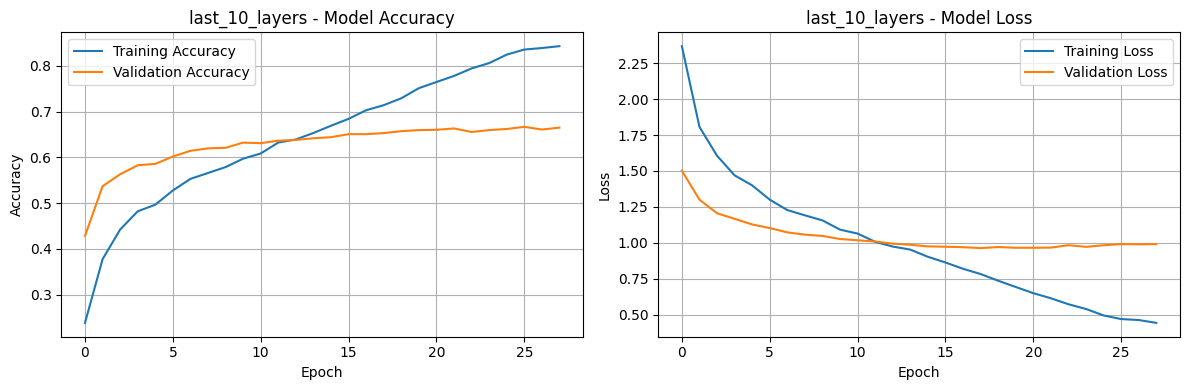


Test Results for last_10_layers:
Test Loss: 0.9707
Test Accuracy: 0.6504

Training Strategy: frozen
Description: All base model layers frozen
Before unfreezing:
  Mel base model trainable: True
  Chroma base model trainable: True
Applying unfreezing strategy: frozen
Base model mel layers: 175
Base model chroma layers: 175
Keeping all base model layers frozen

Verification after unfreezing:
Trainable mel layers: 0/175
Trainable chroma layers: 0/175
Total parameters: 49,409,287
Trainable parameters: 2,232,327
Frozen parameters: 47,176,960
Trainable percentage: 4.52%
Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.3885 - loss: 1.8463
Epoch 1: val_accuracy improved from -inf to 0.55185, saving model to best_model_frozen.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 101s 324ms/step - accuracy: 0.3888 - loss: 1.8450 - val_accuracy: 0.5518 - val_loss: 1.1711 - learning_rate: 0.0010
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5337 - loss: 1.2405
Epoch 2: val_a

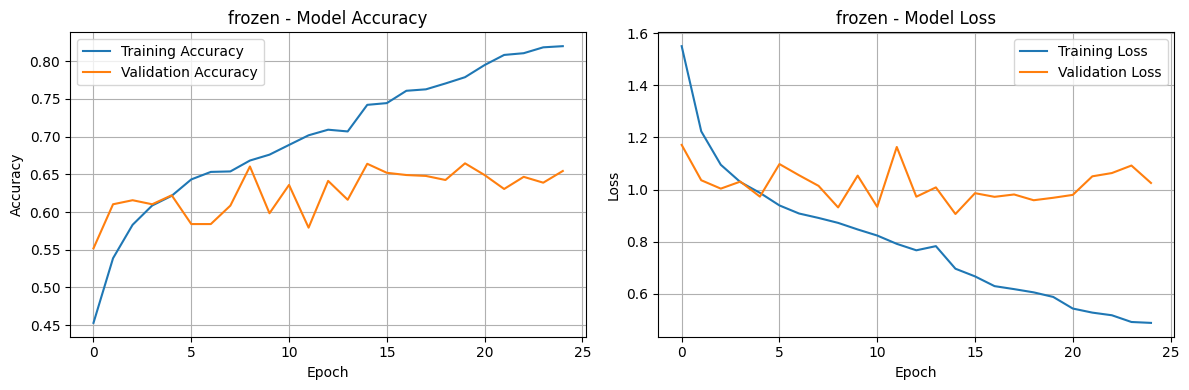


Test Results for frozen:
Test Loss: 0.9268
Test Accuracy: 0.6575

Training Strategy: last_20_layers
Description: Last 20 layers unfrozen
Before unfreezing:
  Mel base model trainable: True
  Chroma base model trainable: True
Applying unfreezing strategy: last_20_layers
Base model mel layers: 175
Base model chroma layers: 175
Unfreezing last 20 layers in mel model
Unfreezing last 20 layers in chroma model
  Mel: Unfrozen layer conv5_block2_1_conv
  Mel: Unfrozen layer conv5_block2_1_bn
  Mel: Unfrozen layer conv5_block2_1_relu
  Mel: Unfrozen layer conv5_block2_2_conv
  Mel: Unfrozen layer conv5_block2_2_bn
  Mel: Unfrozen layer conv5_block2_2_relu
  Mel: Unfrozen layer conv5_block2_3_conv
  Mel: Unfrozen layer conv5_block2_3_bn
  Mel: Unfrozen layer conv5_block2_add
  Mel: Unfrozen layer conv5_block2_out
  Mel: Unfrozen layer conv5_block3_1_conv
  Mel: Unfrozen layer conv5_block3_1_bn
  Mel: Unfrozen layer conv5_block3_1_relu
  Mel: Unfrozen layer conv5_block3_2_conv
  Mel: Unfrozen l

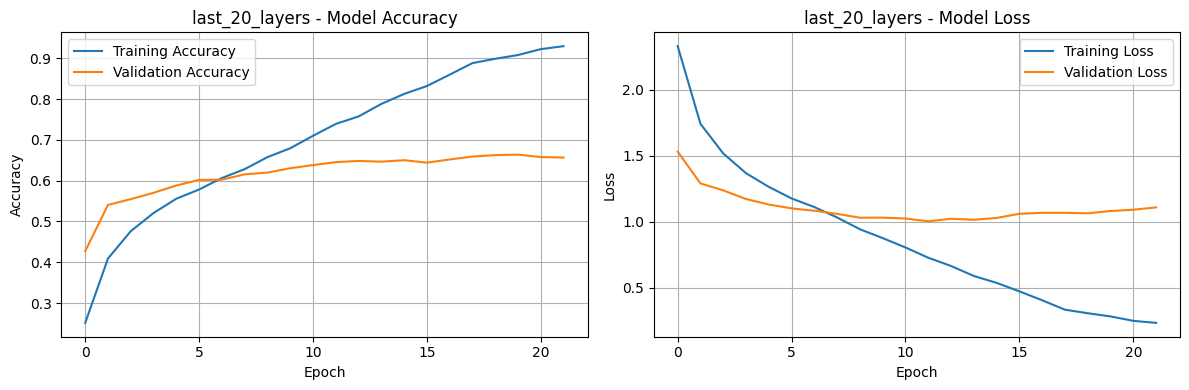


Test Results for last_20_layers:
Test Loss: 0.9918
Test Accuracy: 0.6462

Training Strategy: last_2_blocks
Description: Last 2 ResNet blocks unfrozen (conv5_block and conv4_block)
Before unfreezing:
  Mel base model trainable: True
  Chroma base model trainable: True
Applying unfreezing strategy: last_2_blocks
Base model mel layers: 175
Base model chroma layers: 175
Unfreezing mel blocks: ['conv5_block', 'conv4_block']
Unfreezing chroma blocks: ['conv5_block', 'conv4_block']
  Mel: Unfrozen layer conv4_block1_1_conv
  Mel: Unfrozen layer conv4_block1_1_bn
  Mel: Unfrozen layer conv4_block1_1_relu
  Mel: Unfrozen layer conv4_block1_2_conv
  Mel: Unfrozen layer conv4_block1_2_bn
  Mel: Unfrozen layer conv4_block1_2_relu
  Mel: Unfrozen layer conv4_block1_0_conv
  Mel: Unfrozen layer conv4_block1_3_conv
  Mel: Unfrozen layer conv4_block1_0_bn
  Mel: Unfrozen layer conv4_block1_3_bn
  Mel: Unfrozen layer conv4_block1_add
  Mel: Unfrozen layer conv4_block1_out
  Mel: Unfrozen layer conv4_b

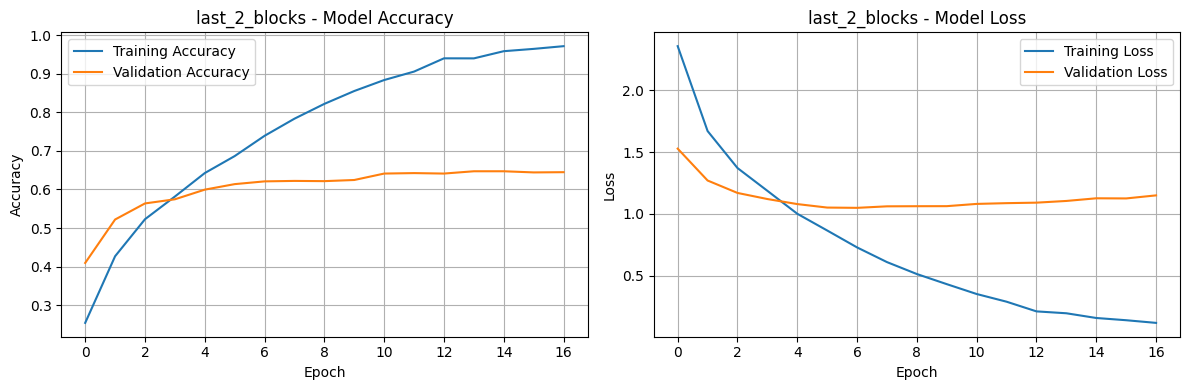


Test Results for last_2_blocks:
Test Loss: 1.0248
Test Accuracy: 0.6218

Training Strategy: last_3_blocks
Description: Last 3 ResNet blocks unfrozen
Before unfreezing:
  Mel base model trainable: True
  Chroma base model trainable: True
Applying unfreezing strategy: last_3_blocks
Base model mel layers: 175
Base model chroma layers: 175
Unfreezing mel blocks: ['conv5_block', 'conv4_block', 'conv3_block']
Unfreezing chroma blocks: ['conv5_block', 'conv4_block', 'conv3_block']
  Mel: Unfrozen layer conv3_block1_1_conv
  Mel: Unfrozen layer conv3_block1_1_bn
  Mel: Unfrozen layer conv3_block1_1_relu
  Mel: Unfrozen layer conv3_block1_2_conv
  Mel: Unfrozen layer conv3_block1_2_bn
  Mel: Unfrozen layer conv3_block1_2_relu
  Mel: Unfrozen layer conv3_block1_0_conv
  Mel: Unfrozen layer conv3_block1_3_conv
  Mel: Unfrozen layer conv3_block1_0_bn
  Mel: Unfrozen layer conv3_block1_3_bn
  Mel: Unfrozen layer conv3_block1_add
  Mel: Unfrozen layer conv3_block1_out
  Mel: Unfrozen layer conv3_bl

KeyboardInterrupt: 

In [21]:
# Cell 11: Execute all training strategies - FIXED
num_classes = len(label_encoder.classes_)

# FIXED: Create dummy base models just to pass to the function
dummy_model, dummy_mel, dummy_chroma = create_multi_input_resnet(num_classes)
strategies = get_unfreezing_strategies(dummy_mel, dummy_chroma)
del dummy_model, dummy_mel, dummy_chroma  # Clean up

results = {}

for strategy_name, strategy_config in strategies.items():
    try:
        model, history = train_strategy(
            strategy_name, strategy_config,
            X_mel_train, X_chroma_train, y_train,
            X_mel_val, X_chroma_val, y_val,
            num_classes
        )

        # Evaluate on test set
        test_loss, test_accuracy = model.evaluate(
            [X_mel_test, X_chroma_test], y_test, verbose=0
        )

        print(f"\nTest Results for {strategy_name}:")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

        # Store results
        results[strategy_name] = {
            'model': model,
            'history': history,
            'test_accuracy': test_accuracy,
            'test_loss': test_loss
        }

        # Clear memory
        del model
        tf.keras.backend.clear_session()
        gc.collect()

    except Exception as e:
        print(f"Error training {strategy_name}: {e}")
        continue

# ADDED: Print final comparison
print("\n" + "="*60)
print("FINAL RESULTS COMPARISON")
print("="*60)
for strategy_name, result in results.items():
    print(f"{strategy_name:20s}: {result['test_accuracy']:.4f}")

In [ ]:
# Cell 12: Compare results and generate detailed classification reports
print("\n" + "="*80)
print("FINAL RESULTS COMPARISON")
print("="*80)

# Summary table
summary_data = []
for strategy_name, result in results.items():
    summary_data.append({
        'Strategy': strategy_name,
        'Test Accuracy': f"{result['test_accuracy']:.4f}",
        'Test Loss': f"{result['test_loss']:.4f}",
        'Best Val Accuracy': f"{max(result['history'].history['val_accuracy']):.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Detailed classification report for best model
best_strategy = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
best_model = results[best_strategy]['model']

print(f"\nDetailed Classification Report for Best Model ({best_strategy}):")
print("-" * 60)

# Load best model
best_model.load_weights(f'best_model_{best_strategy}.h5')

# Predictions
y_pred = best_model.predict([X_mel_test, X_chroma_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(
    y_true_classes, y_pred_classes,
    target_names=label_encoder.classes_
))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_strategy}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
